# Spherical Fourier Neural Operators

A simple notebook to showcase spherical Fourier Neural Operators


## Preparation

In [1]:
import paddle
import paddle.nn as nn
from paddle.io import DataLoader
from paddle import amp
from paddle.optimizer.lr import OneCycleLR

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from math import ceil, sqrt

import time

cmap='twilight_shifted'

c:\Users\lixia\AppData\Local\anaconda3\envs\paddle310\lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:686: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


In [2]:
enable_amp = False

# set device
device = paddle.set_device('gpu' if paddle.device.cuda.device_count() != 0 else 'cpu')

### Training data
to train our geometric FNOs, we require training data. To this end let us prepare a Dataloader which computes results on the fly:

In [3]:
# dataset
import sys
sys.path.append("..")
from paddle_harmonics.examples.sfno import PdeDataset

# 1 hour prediction steps
dt = 1*3600
dt_solver = 150
nsteps = dt//dt_solver
dataset = PdeDataset(dt=dt, nsteps=nsteps, dims=(256, 512), device=device, normalize=True)
# There is still an issue with parallel dataloading. Do NOT use it at the moment
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0, persistent_workers=False)
solver = dataset.solver.to(device)

nlat = dataset.nlat
nlon = dataset.nlon

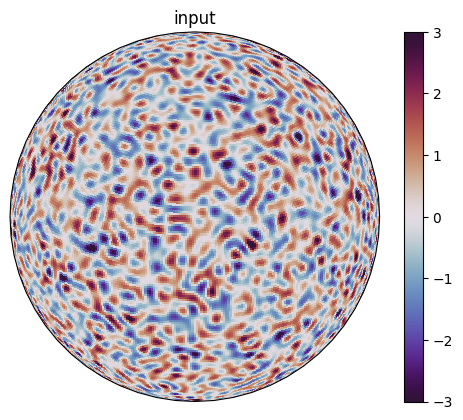

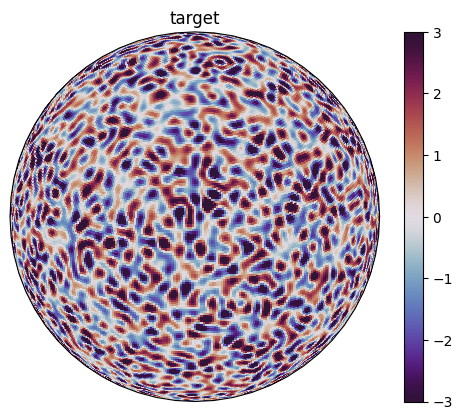

In [4]:
paddle.seed(0)
inp, tar = dataset[0]

fig = plt.figure()
im = solver.plot_griddata(inp[2], fig, vmax=3, vmin=-3)
plt.title("input")
plt.colorbar(im)
plt.show()

fig = plt.figure()
im = solver.plot_griddata(tar[2], fig, vmax=3, vmin=-3)
plt.title("target")
plt.colorbar(im)
plt.show()

### Defining the geometric Fourier Neural Operator

In [5]:
from paddle_harmonics.examples.sfno import SphericalFourierNeuralOperatorNet as SFNO

In [6]:
model = SFNO(spectral_transform='sht', operator_type='driscoll-healy', img_size=(nlat, nlon), grid="equiangular",
                 num_layers=4, scale_factor=3, embed_dim=16, big_skip=True, pos_embed="lat", use_mlp=False, normalization_layer="none").to(device)


In [7]:
# pointwise model for sanity checking
# class MLP(nn.Module):
#     def __init__(self,
#                  input_dim = 3,
#                  output_dim = 3,
#                  num_layers = 2,
#                  hidden_dim = 32,
#                  activation_function = nn.ReLU,
#                  bias = False):
#         super().__init__()
    
#         current_dim = input_dim
#         layers = []
#         for l in range(num_layers-1):
#             fc = nn.Conv2d(current_dim, hidden_dim, 1, bias=True)
#             # initialize the weights correctly
#             scale = sqrt(2. / current_dim)
#             nn.init.normal_(fc.weight, mean=0., std=scale)
#             if fc.bias is not None:
#                 nn.init.constant_(fc.bias, 0.0)
#             layers.append(fc)
#             layers.append(activation_function())
#             current_dim = hidden_dim
#         fc = nn.Conv2d(current_dim, output_dim, 1, bias=False)
#         scale = sqrt(1. / current_dim)
#         nn.init.normal_(fc.weight, mean=0., std=scale)
#         if fc.bias is not None:
#             nn.init.constant_(fc.bias, 0.0)
#         layers.append(fc)
#         self.mlp = nn.Sequential(*layers)

#     def forward(self, x):
#         return self.mlp(x)

# model = MLP(num_layers=10).to(device)

## Training the model

In [8]:
def l2loss_sphere(solver, prd, tar, relative=False, squared=True):
    loss = solver.integrate_grid((prd - tar)**2, dimensionless=True).sum(axis=-1)
    if relative:
        loss = loss / solver.integrate_grid(tar**2, dimensionless=True).sum(axis=-1)
    
    if not squared:
        loss = paddle.sqrt(loss)
    loss = loss.mean()

    return loss

def spectral_l2loss_sphere(solver, prd, tar, relative=False, squared=True):
    # compute coefficients
    coeffs = paddle.as_real(solver.sht(prd - tar))
    coeffs = coeffs[..., 0]**2 + coeffs[..., 1]**2
    norm2 = coeffs[..., :, 0] + 2 * paddle.sum(coeffs[..., :, 1:], axis=-1)
    loss = paddle.sum(norm2, axis=(-1,-2))

    if relative:
        tar_coeffs = paddle.as_real(solver.sht(tar))
        tar_coeffs = tar_coeffs[..., 0]**2 + tar_coeffs[..., 1]**2
        tar_norm2 = tar_coeffs[..., :, 0] + 2 * paddle.sum(tar_coeffs[..., :, 1:], axis=-1)
        tar_norm2 = paddle.sum(tar_norm2, axis=(-1,-2))
        loss = loss / tar_norm2

    if not squared:
        loss = paddle.sqrt(loss)
    loss = loss.mean()

    return loss

In [9]:
# training function
def train_model(model, dataloader, optimizer, scheduler=None, nepochs=20, nfuture=0, num_examples=256, num_valid=8, loss_fn='l2'):

    train_start = time.time()

    for epoch in range(nepochs):

        # time each epoch
        epoch_start = time.time()

        dataloader.dataset.set_initial_condition('random')
        dataloader.dataset.set_num_examples(num_examples)

        optimizer.clear_gradients(set_to_zero=False)

        # do the training
        acc_loss = 0
        model.train()
        for inp, tar in dataloader:
            with amp.auto_cast(enable=enable_amp):
                prd = model(inp)
                for _ in range(nfuture):
                    prd = model(prd)
                if loss_fn == 'l2':
                    loss = l2loss_sphere(solver, prd, tar)
                elif loss_fn == "spectral l2":
                    loss = spectral_l2loss_sphere(solver, prd, tar)

            acc_loss += loss.item() * inp.shape[0]

            optimizer.clear_gradients(set_to_zero=True)
            # gscaler.scale(loss).backward()
            loss.backward()
            optimizer.step()
            # gscaler.update()

        if scheduler is not None:
            scheduler.step()

        acc_loss = acc_loss / len(dataloader.dataset)

        dataloader.dataset.set_initial_condition('random')
        dataloader.dataset.set_num_examples(num_valid)

        # perform validation
        valid_loss = 0
        model.eval()
        with paddle.no_grad():
            for inp, tar in dataloader:
                prd = model(inp)
                for _ in range(nfuture):
                    prd = model(prd)
                loss = l2loss_sphere(solver, prd, tar, relative=True)

                valid_loss += loss.item() * inp.shape[0]

        valid_loss = valid_loss / len(dataloader.dataset)

        epoch_time = time.time() - epoch_start

        print(f'--------------------------------------------------------------------------------')
        print(f'Epoch {epoch} summary:')
        print(f'time taken: {epoch_time}')
        print(f'accumulated training loss: {acc_loss}')
        print(f'relative validation loss: {valid_loss}')

    train_time = time.time() - train_start

    print(f'--------------------------------------------------------------------------------')
    print(f'done. Training took {train_time}.')
    return valid_loss

In [10]:
# set seed
paddle.seed(333)

optimizer = paddle.optimizer.Adam(parameters=model.parameters(), learning_rate=3E-3, weight_decay=0.0)
gscaler = amp.GradScaler(enable=enable_amp)
train_model(model, dataloader, optimizer, nepochs=10)

# multistep training
# learning_rate = 5e-4
# optimizer = torch.optim.Adam(fno_model.parameters(), lr=learning_rate)
# dataloader.dataset.nsteps = 2 * dt//dt_solver
# train_model(fno_model, dataloader, optimizer, nepochs=10, nfuture=1)
# dataloader.dataset.nsteps = 1 * dt//dt_solver

--------------------------------------------------------------------------------
Epoch 0 summary:
time taken: 48.82363510131836
accumulated training loss: 71.2744810283184
relative validation loss: 0.29547473788261414
--------------------------------------------------------------------------------
Epoch 1 summary:
time taken: 65.14887142181396
accumulated training loss: 10.439824938774109
relative validation loss: 0.16412179172039032
--------------------------------------------------------------------------------
Epoch 2 summary:
time taken: 70.83619928359985
accumulated training loss: 6.304196134209633
relative validation loss: 0.10636528581380844
--------------------------------------------------------------------------------
Epoch 3 summary:
time taken: 43.78714060783386
accumulated training loss: 4.306027360260487
relative validation loss: 0.0766853541135788
--------------------------------------------------------------------------------
Epoch 4 summary:
time taken: 43.463710308074

0.013103933539241552

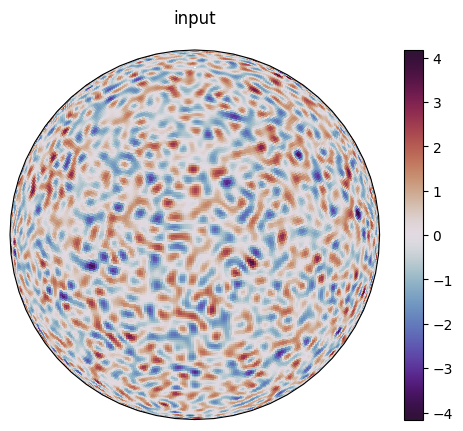

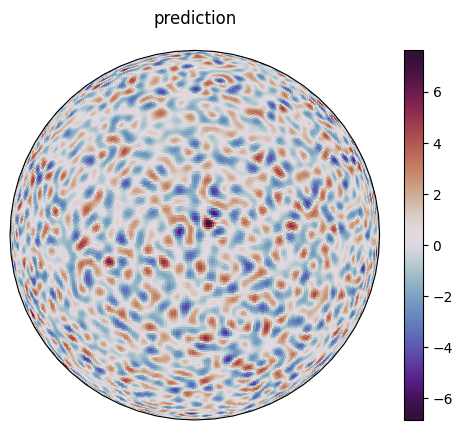

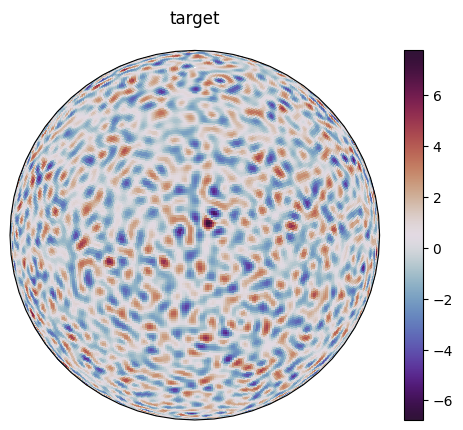

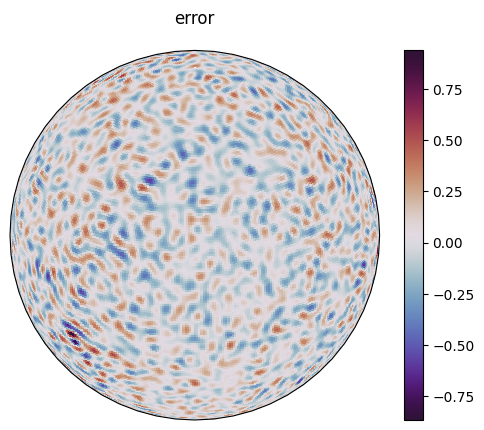

In [12]:
dataloader.dataset.set_initial_condition('random')

paddle.seed(0)

with paddle.no_grad():
    inp, tar = next(iter(dataloader))
    out = model(inp).detach()

s = 0; ch = 2

fig = plt.figure()
im = solver.plot_griddata(inp[s, ch], fig, projection='3d', title='input')
plt.colorbar(im)
plt.show()

fig = plt.figure()
im = solver.plot_griddata(out[s, ch], fig, projection='3d', title='prediction')
plt.colorbar(im)
plt.show()

fig = plt.figure()
im = solver.plot_griddata(tar[s, ch], fig, projection='3d', title='target')
plt.colorbar(im)
plt.show()

fig = plt.figure()
im = solver.plot_griddata((tar-out)[s, ch], fig, projection='3d', title='error')
plt.colorbar(im)
plt.show()